# # 玩具数据
步骤

数据处理

模型定义

训练循环

交互测试

In [ ]:
#问题1： cmn文件里面的标注代表什么
#问题2：he is lazy的图片代表什么
#问题3：BPE下面的iteration10代表什么

In [1]:
# 首先导入需要的工具包
import string
import re
import random

# 我们使用pytorch框架完成这个任务
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 计算设备对象，后续的操作中会使用该对象。如果CUDA可用的话，将使用GPU进行计算，否则使用CPU。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def reset_seed():
    random.seed(1211)
    torch.manual_seed(1211)
    torch.cuda.manual_seed(1211)

In [11]:
SOS=0
EOS=1
MAX_LENGTH = 10
PREFIXS = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def clean_latin_text(s):
    # 按空格分词
    s = s.lower().strip() # 小写并清除首尾空白字符
    s = re.sub(r"([.!?])", r" \1", s) # 标点前添加空格
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # 清除其它符号
    return s

def clean_zh_text(s):
    # 分字
    s = s.strip()
    s = ' '.join([char for char in s])
    return s


def filter_by_en(en, zh):
    # 只保留简单的句子
    return (len(en.split(' ')) < MAX_LENGTH and
        len(zh.split(' ')) < MAX_LENGTH and
        en.startswith(PREFIXS))

class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {'<SOS>': 0, '<EOS>': 1}
        self.word2count = {}
        self.index2word = {0: '<SOS>', 1: '<EOS>'}


    def __len__(self):
        return len(self.word2index)

    def add_sentence(self, sentence):

        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = len(self)
            self.word2count[word] = 1
            self.index2word[len(self)-1] = word
        else:
            self.word2count[word] += 1


#def read_text(filename='05/cmn.txt'): 任宣成原来的
def read_text(filename='D:/NLP/机器学习/cmn-eng/cmn.txt',encoding='utf-8'):
    print('reading text...')
    ens = []
    zhs = []

    vocab_en = Vocab('en')
    vocab_zh = Vocab('zh')

    # 用于繁简转换
    import zhconv

    with open(filename, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.split('\t')
            en, zh = parts[0], parts[1]
            en = clean_latin_text(en)
            zh = zhconv.convert(zh, 'zh-cn')
            zh = clean_zh_text(zh)
            if filter_by_en(en, zh):
                ens.append(en)
                zhs.append(zh)
                vocab_en.add_sentence(en)
                vocab_zh.add_sentence(zh)

    print(f'Read {len(ens)} pairs')
    print(f'en: {len(vocab_en)} token types')
    print(f'zh: {len(vocab_zh)} token types')
    return ens, zhs, vocab_en, vocab_zh


ens, zhs, vocab_en, vocab_zh = read_text()
pairs = [[en, zh] for en, zh in zip(ens, zhs)]

reset_seed()
ex = random.choice(pairs)
print(ex)

reading text...
Read 1030 pairs
en: 884 token types
zh: 870 token types
['he s very angry with you .', '他 对 你 非 常 生 气 。']


In [3]:
#pip install zhconv，提示安装繁简转换的工具

Note: you may need to restart the kernel to use updated packages.


In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__() # 必须在添加参数前初始化基类
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, input):
        # 输入单位为句子
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded)
        return output, hidden


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, 1)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # 输入单位为词
        # hidden should be [1, 1, hidden]
        # encoder_outputs shoud be [1, src_len, hidden]
        embedded = self.embedding(input).view(1, 1, -1)

        # [1, 1, hidden], [1, 1, hidden]
        output, hidden = self.gru(embedded, hidden)

        # [1, src_len]
        # 这里Attention的实现方法是，将解码器的隐状态与编码器的输出合并
        # 然后经过一个变化，输出每个位置对的分数
        attn_weights = self.attn(torch.cat([hidden.expand_as(encoder_outputs), encoder_outputs], dim=-1)).view(1, -1)
        attn_weights = F.softmax(attn_weights, dim=1)

        # [1, hidden] 这里是对编码器输出进行加权平均
        attn_applied = torch.mm(attn_weights, encoder_outputs[0])

        # [1, hidden]
        output = F.relu(self.attn_combine(torch.cat([output[0], attn_applied], dim=1)))

        output = self.out(output)

        return output, hidden, attn_weights

In [13]:
# 数字化句子对
def binarize_text(line, vocab):
    idxs =  [vocab.word2index[word] for word in line.split(' ')]
    return torch.tensor(idxs, dtype=torch.long, device=device).view(1, -1)

def string_text(tensor, vocab):
    idxs = tensor.tolist()[0]
    return ' '.join([vocab.index2word[idx] for idx in idxs])

def tensor_from_pair(pair):
    return binarize_text(pair[0] + ' <EOS>', vocab_en), binarize_text('<SOS> ' + pair[1] + ' <EOS>', vocab_zh)

def recover_from_tensor(pair):
    return string_text(pair[0], vocab_en), string_text(pair[1], vocab_zh)

# 注意，为了使得模型更好的捕获控制信号，我们会额外添加<SOS>和<EOS>符号
print(tensor_from_pair(ex))
print(recover_from_tensor(tensor_from_pair(ex)))

(tensor([[ 14,  15,  86, 128, 319,  51,   5,   1]], device='cuda:0'), tensor([[  0,  19,  28,  76, 187, 188,   6, 194,   5,   1]], device='cuda:0'))
('he s very angry with you . <EOS>', '<SOS> 他 对 你 非 常 生 气 。 <EOS>')


In [14]:
# 每个训练步骤，由前向传播、反向传播和参数更新构成
def train_step(input_tensor, target_tensor,
          encoder, decoder,
          encoder_optimizer, decoder_optimizer,
          criterion):

    # optimizer
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    # encode [1, src_len, hidden_size], [1, 1, hidden_size]
    encoder_outputs, encoder_hidden = encoder(input_tensor)

    # decode
    decoder_outputs = []
    decoder_hidden = encoder_hidden # [1, 1, hidden_size]

    # Teacher forcing
    for di in range(target_length - 1):
        # [1, out], [1, 1, hidden], [1, src_len]
        decoder_output, decoder_hidden, decoder_attention = decoder(
            target_tensor[:, di], decoder_hidden, encoder_outputs)
        decoder_outputs.append(decoder_output)

    decoder_outputs = torch.stack(decoder_outputs, dim=1)[0] # [tgt_len, vocab]
    decoder_targets = target_tensor[0, 1:] # [tgt_len]
    loss = criterion(decoder_outputs, decoder_targets)
    # backprop
    loss.backward()

    # update
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / (target_length - 1)

In [15]:
# 整个训练的循环，我们训练固定的次数
def train(encoder, decoder, n_iters, print_every=100,
               learning_rate=0.001):
    reset_seed()
    print_loss_total = 0  # Reset every print_every

    # 初始化优化器和优化目标
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = tensor_from_pair(random.choice(pairs)) # 随机选择一个句子对进行训练
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_step(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'| iter {iter:03d}/{n_iters:03d} | loss {print_loss_avg:.4f}')

In [16]:
reset_seed()
hidden_size = 128

encoder1 = EncoderRNN(len(vocab_en), hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, len(vocab_zh)).to(device)

train(encoder1, attn_decoder1, 10000)

| iter 100/10000 | loss 0.6155
| iter 200/10000 | loss 0.4920
| iter 300/10000 | loss 0.4731
| iter 400/10000 | loss 0.4806
| iter 500/10000 | loss 0.4508
| iter 600/10000 | loss 0.4479
| iter 700/10000 | loss 0.4428
| iter 800/10000 | loss 0.4267
| iter 900/10000 | loss 0.4364
| iter 1000/10000 | loss 0.3911
| iter 1100/10000 | loss 0.3953
| iter 1200/10000 | loss 0.3704
| iter 1300/10000 | loss 0.3774
| iter 1400/10000 | loss 0.3633
| iter 1500/10000 | loss 0.3672
| iter 1600/10000 | loss 0.3461
| iter 1700/10000 | loss 0.3808
| iter 1800/10000 | loss 0.3316
| iter 1900/10000 | loss 0.3598
| iter 2000/10000 | loss 0.3130
| iter 2100/10000 | loss 0.2990
| iter 2200/10000 | loss 0.3019
| iter 2300/10000 | loss 0.2984
| iter 2400/10000 | loss 0.2756
| iter 2500/10000 | loss 0.2607
| iter 2600/10000 | loss 0.2714
| iter 2700/10000 | loss 0.2668
| iter 2800/10000 | loss 0.2765
| iter 2900/10000 | loss 0.2305
| iter 3000/10000 | loss 0.2374
| iter 3100/10000 | loss 0.2258
| iter 3200/10000

In [17]:
def inference(encoder, decoder, sentence):
    with torch.no_grad():
        input_tensor = binarize_text(clean_latin_text(sentence) + ' <EOS>', vocab_en)
        input_length = input_tensor.size()[1]

        # encode [1, src_len, hidden_size], [1, 1, hidden_size]
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # decode
        decoder_words = ['<SOS>']
        decoder_hidden = encoder_hidden # [1, 1, hidden_size]
        decoder_attentions = []

        for _ in range(MAX_LENGTH):
            last_word = decoder_words[-1]
            last_word_idx = vocab_zh.word2index[last_word]
            decoder_input = torch.tensor([[last_word_idx]], device=device)

            # [1, out], [1, 1, hidden], [1, src_len]
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention)

            word_idx = torch.argmax(decoder_output[0])
            word = vocab_zh.index2word[word_idx.item()]
            decoder_words.append(word)
            if word == '<EOS>':
                break

        # [tgt_len, src_len]
        decoder_attentions = torch.cat(decoder_attentions, dim=0).tolist()

        return decoder_words, decoder_attentions

In [18]:
def evaluate_randomly(encoder, decoder, n=10):
    # 随机选择几个句子查看学习的效果
    reset_seed()
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = inference(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words[1:])
        print('<', output_sentence)
        print('')

evaluate_randomly(encoder1, attn_decoder1)

> he s very angry with you .
= 他 对 你 非 常 生 气 。
< 他 非 常 生 气 。 <EOS>

> you are responsible for the result .
= 你 要 对 结 果 负 责 。
< 你 要 对 结 果 负 责 。 <EOS>

> he is to come to my house tonight .
= 他 今 晚 会 来 我 家 。
< 他 今 晚 会 来 我 家 。 <EOS>

> they re digging a hole .
= 他 们 正 在 挖 一 个 洞 。
< 他 们 正 在 聊 他 的 书 。 <EOS>

> i m hoping that ll happen .
= 我 希 望 那 会 发 生 。
< 我 希 望 那 会 发 生 。 <EOS>

> i m free tonight .
= 我 今 晚 有 空 。
< 我 今 晚 离 开 。 <EOS>

> they are very big .
= 他 们 非 常 大 。
< 他 们 非 常 快 。 <EOS>

> i am playing the piano now .
= 我 现 在 正 在 弹 钢 琴 。
< 我 现 在 正 在 弹 钢 琴 。 <EOS>

> i m not too smart .
= 我 不 太 聪 明 。
< 我 不 太 聪 明 。 <EOS>

> i m married .
= 我 已 婚 。
< 我 已 婚 。 <EOS>



input = i m ok .
output = <SOS> 我 没 事 。 <EOS>


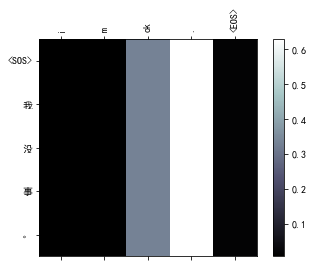

input = he s lazy .
output = <SOS> 他 很 懒 。 <EOS>


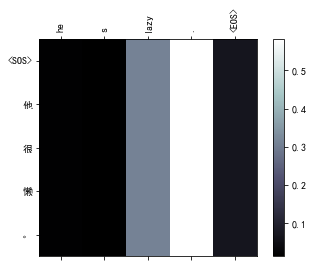

input = i m sorry .
output = <SOS> 我 在 做 不 起 。 <EOS>


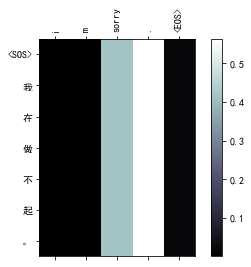

input = i m lazy .
output = <SOS> 我 很 好 。 <EOS>


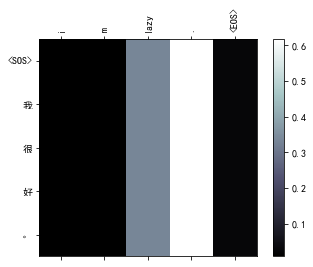

In [20]:
# 使用matplotlib进行可视化，纵坐标为目标的输入词，横坐标为源语言句子

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
import matplotlib.ticker as ticker

def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = inference(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

pairs = [[en, zh] for en, zh in zip(ens, zhs)]
evaluate_and_show_attention(pairs[0][0])
evaluate_and_show_attention(pairs[10][0])
evaluate_and_show_attention(pairs[20][0])
evaluate_and_show_attention('i m lazy .')

In [ ]:
**BPE**

In [21]:
import re, collections

from IPython.display import display, Markdown
def show_bold(string):
    display(Markdown(f'**{string}**'))

def show_heading(string, level=4):
    display(Markdown('#'*level + ' ' + string))


def get_stats(vocab):
    """Compute frequencies of adjacent pairs of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

In [22]:
train_data = {
    'l o w </w>': 5,
    'l o w e r </w>': 2,
    'n e w e s t </w>': 6,
    'w i d e s t </w>': 3
}

bpe_codes = {}
bpe_codes_reverse = {}

num_merges = 10

for i in range(num_merges):
    show_bold(f"Iteration {i+1}")
    pairs = get_stats(train_data)
    best = max(pairs, key=pairs.get)
    train_data = merge_vocab(best, train_data)

    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best

    print("new merge: {}".format(best))
    print("train data: {}".format(train_data))

**Iteration 1**

new merge: ('e', 's')
train data: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}


**Iteration 2**

new merge: ('es', 't')
train data: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}


**Iteration 3**

new merge: ('est', '</w>')
train data: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


**Iteration 4**

new merge: ('l', 'o')
train data: {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


**Iteration 5**

new merge: ('lo', 'w')
train data: {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


**Iteration 6**

new merge: ('n', 'e')
train data: {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i d est</w>': 3}


**Iteration 7**

new merge: ('ne', 'w')
train data: {'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i d est</w>': 3}


**Iteration 8**

new merge: ('new', 'est</w>')
train data: {'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


**Iteration 9**

new merge: ('low', '</w>')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


**Iteration 10**

new merge: ('w', 'i')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}


In [23]:
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as a tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def encode(orig):
    """Encode word based on list of BPE merge operations, which are applied consecutively"""

    word = tuple(orig) + ('</w>',)
    print("word split into characters: {}".format(word))

    pairs = get_pairs(word)

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        show_bold(f"Iteration {iteration}:")

        print(f"bigrams in the word: {pairs}")
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        print(f"candidate for merging: {bigram}")
        if bigram not in bpe_codes:
            print("Candidate not in BPE merges, algorithm stops.")
            break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_word = tuple(new_word)
        word = new_word
        print(f"word after merging: {word}")
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # don't print end-of-word symbols
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)

    return word

In [24]:
encode("lowest")

word split into characters: ('l', 'o', 'w', 'e', 's', 't', '</w>')


**Iteration 1:**

bigrams in the word: {('t', '</w>'), ('w', 'e'), ('s', 't'), ('e', 's'), ('o', 'w'), ('l', 'o')}
candidate for merging: ('e', 's')
word after merging: ('l', 'o', 'w', 'es', 't', '</w>')


**Iteration 2:**

bigrams in the word: {('t', '</w>'), ('o', 'w'), ('w', 'es'), ('l', 'o'), ('es', 't')}
candidate for merging: ('es', 't')
word after merging: ('l', 'o', 'w', 'est', '</w>')


**Iteration 3:**

bigrams in the word: {('est', '</w>'), ('l', 'o'), ('o', 'w'), ('w', 'est')}
candidate for merging: ('est', '</w>')
word after merging: ('l', 'o', 'w', 'est</w>')


**Iteration 4:**

bigrams in the word: {('w', 'est</w>'), ('l', 'o'), ('o', 'w')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'est</w>')


**Iteration 5:**

bigrams in the word: {('w', 'est</w>'), ('lo', 'w')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'est</w>')


**Iteration 6:**

bigrams in the word: {('low', 'est</w>')}
candidate for merging: ('low', 'est</w>')
Candidate not in BPE merges, algorithm stops.


('low', 'est')

In [ ]:
**BERT模型**

In [25]:
from transformers import (BertTokenizer, OpenAIGPTTokenizer,
    TransfoXLTokenizer, GPT2Tokenizer,  XLMTokenizer, XLNetTokenizer, RobertaTokenizer)


tokenizers ={
    'bert-base-cased': BertTokenizer.from_pretrained('bert-base-cased'),
    'bert-base-multilingual-cased': BertTokenizer.from_pretrained('bert-base-multilingual-cased'),
    'bert-base-chinese': BertTokenizer.from_pretrained('bert-base-chinese'),
    'gpt': OpenAIGPTTokenizer.from_pretrained('openai-gpt'),
    'gpt2': GPT2Tokenizer.from_pretrained('gpt2'),
    'transformerxl': TransfoXLTokenizer.from_pretrained('transfo-xl-wt103'),
    'xlnet-base-cased':  XLNetTokenizer.from_pretrained('xlnet-base-cased'),
    'xlm-mlm-en': XLMTokenizer.from_pretrained('xlm-mlm-en-2048'),
    'xlm-mlm-tlm-xnli15-1024': XLMTokenizer.from_pretrained('xlm-mlm-tlm-xnli15-1024'),
    'roberta-base': RobertaTokenizer.from_pretrained('roberta-base'),
}

100%|███████████████████████████████████████████████████████████████████████| 458495/458495 [00:01<00:00, 276237.86B/s]
ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
100%|███████████████████████████████████████████████████████████████████████| 456318/456318 [00:01<00:00, 249499.41B/s]


In [26]:
def transformers_tokenize_sentence(sentence):
    print(f'sentence:\n{sentence}')
    print()
    for name, tok in tokenizers.items():
        print(f'{name}:\n{tok.tokenize(sentence)}')
        print()
        print(f'{name} (recover):\n{tok.decode(tok.encode(sentence))}')
        print()
    print()

In [27]:
texts = [
    'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.',
    '独角兽是一种传说生物，形象通常为头上长有独角的白马。现实世界中，独角鲸也许是这个神话动物的原型，不过独角鲸生活在遥远的北冰洋的深海而不是山川草原。生活在陆地上的犀牛，前额也有一只尖利的角，可惜相貌差距甚远。也有人说，独角兽其实就是已灭绝的板齿犀，亦称为西伯利亚独角兽，大约在2.9万年前灭绝。',
    'El unicornio es una criatura mitológica representada habitualmente como un caballo blanco con patas de antílope, ojos y barba de chivo y un cuerno en la frente.',
    "La licorne, parfois nommée unicorne, est une créature légendaire à corne unique. Son origine, controversée, résulte de multiples influences, en particulier de descriptions d'animaux tels que le rhinocéros et l'antilope, issues de récits d'explorateurs.",
    'Das Einhorn (lat. unicornis, griech. monókeros) ist ein Fabelwesen von Pferde- oder Ziegengestalt mit einem geraden Horn auf der Stirnmitte.',
    'Miley Cyrus was caught shoplifting from Abercrombie and Fitch on Hollywood Boulevard today.',
    'We’ve trained a large language model called GPT-2 that generates realistic paragraphs of text, while also exhibiting zero shot generalization on tasks like machine translation, question answering, reading comprehension, and summarization - problems usually approached by using training datasets and models designed explicitly for these tasks.',
    'こんにちは世界。',
    '你好，世界。',
    'Hello, world.',

]

In [28]:
for i, sent in enumerate(texts):
    show_bold(f'Sentence {i}')
    transformers_tokenize_sentence(sent)

**Sentence 0**

sentence:
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

bert-base-cased:
['In', 'a', 'shocking', 'finding', ',', 'scientist', 'discovered', 'a', 'herd', 'of', 'un', '##icorn', '##s', 'living', 'in', 'a', 'remote', ',', 'previously', 'une', '##x', '##p', '##lore', '##d', 'valley', ',', 'in', 'the', 'Andes', 'Mountains', '.', 'Even', 'more', 'surprising', 'to', 'the', 'researchers', 'was', 'the', 'fact', 'that', 'the', 'un', '##icorn', '##s', 'spoke', 'perfect', 'English', '.']

bert-base-cased (recover):
[CLS] In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. [SEP]

bert-base-multilingual-cased:
['In', 'a', 'shock', '##ing', '

This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
in a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the andes mountains. even more surprising to the researchers was the fact that the unicorns spoke perfect english.

gpt2:
['In', 'Ġa', 'Ġshocking', 'Ġfinding', ',', 'Ġscientist', 'Ġdiscovered', 'Ġa', 'Ġherd', 'Ġof', 'Ġunic', 'orns', 'Ġliving', 'Ġin', 'Ġa', 'Ġremote', ',', 'Ġpreviously', 'Ġunexpl', 'ored', 'Ġvalley', ',', 'Ġin', 'Ġthe', 'ĠAnd', 'es', 'ĠMountains', '.', 'ĠEven', 'Ġmore', 'Ġsurprising', 'Ġto', 'Ġthe', 'Ġresearchers', 'Ġwas', 'Ġthe', 'Ġfact', 'Ġthat', 'Ġthe', 'Ġunic', 'orns', 'Ġspoke', 'Ġperfect', 'ĠEnglish', '.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

transformerxl:
['In', 'a', 'shocking', 'finding,', 'scientist', 'discovered', 'a', 'herd', 'of', 'unicorns', 'living', 'in', 'a', 'remote,', 'previously', 'unexplored', 'valley,', 'in', 'the', 'Andes', 'Mountains.', 'Even', 'more', 'surprising', 'to', 'the', 'researchers', 'was', 'the', 'fact', 'that', 'the', 'unicorns', 'spoke', 'perfect', 'English.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
In a shocking <unk> scientist discovered a herd of unicorns living in a <unk> previously unexplored <unk> in the Andes <unk> Even more surprising to the researchers was the fact that the unicorns spoke perfect <unk>

xlnet-base-cased:
['▁In', '▁a', '▁shocking', '▁finding', ',', '▁scientist', '▁discovered', '▁a', '▁her', 'd', '▁of', '▁', 'uni', 'corn', 's', '▁living', '▁in', '▁a', '▁remote', ',', '▁previously', '▁un', 'exp', 'lor', 'ed', '▁valley', ',', '▁in', '▁the', '▁And', 'es', '▁Mountains', '.', '▁Even', '▁more', '▁surprising', '▁to', '▁the', '▁researchers', '▁was', '▁the', '▁fact', '▁that', '▁the', '▁', 'uni', 'corn', 's', '▁spoke', '▁perfect', '▁English', '.']

xlnet-base-cased (recover):
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.<sep><cls>

xlm-mlm-en:
['in</w>', 'a</w>

**Sentence 1**

sentence:
独角兽是一种传说生物，形象通常为头上长有独角的白马。现实世界中，独角鲸也许是这个神话动物的原型，不过独角鲸生活在遥远的北冰洋的深海而不是山川草原。生活在陆地上的犀牛，前额也有一只尖利的角，可惜相貌差距甚远。也有人说，独角兽其实就是已灭绝的板齿犀，亦称为西伯利亚独角兽，大约在2.9万年前灭绝。

bert-base-cased:
['[UNK]', '[UNK]', '[UNK]', '[UNK]', '一', '[UNK]', '[UNK]', '[UNK]', '生', '[UNK]', '，', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '上', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '白', '[UNK]', '。', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '中', '，', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '神', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '原', '[UNK]', '，', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '生', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '北', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '海', '[UNK]', '[UNK]', '[UNK]', '山', '川', '[UNK]', '原', '。', '生', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '上', '[UNK]', '[UNK]', '[UNK]', '，', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '一', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '，', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]'

This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>2. 9 <unk><unk><unk><unk><unk><unk>

gpt2:
['çĭ', '¬', 'è', '§', 'Ĵ', 'åħ', '½', 'æĺ¯', 'ä¸Ģ', 'ç', '§', 'į', 'ä¼', 'ł', 'è¯', '´', 'çĶŁ', 'çī', '©', 'ï', '¼', 'Į', 'å½', '¢', 'è', '±', '¡', 'éĢ', 'ļ', 'å¸', '¸', 'ä¸', 'º', 'å¤', '´', 'ä¸Ĭ', 'é', 'ķ', '¿', 'æľ', 'ī', 'çĭ', '¬', 'è', '§', 'Ĵ', 'çļĦ',

This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
独角兽是一种传说生物，形象通常为头上长有独角的白马。现实世界中，独角鲸也许是这个神话动物的原型，不过独角鲸生活在遥远的北冰洋的深海而不是山川草原。生活在陆地上的犀牛，前额也有一只尖利的角，可惜相貌差距甚远。也有人说，独角兽其实就是已灭绝的板齿犀，亦称为西伯利亚独角兽，大约在2.9万年前灭绝。

transformerxl:
['独角兽是一种传说生物，形象通常为头上长有独角的白马。现实世界中，独角鲸也许是这个神话动物的原型，不过独角鲸生活在遥远的北冰洋的深海而不是山川草原。生活在陆地上的犀牛，前额也有一只尖利的角，可惜相貌差距甚远。也有人说，独角兽其实就是已灭绝的板齿犀，亦称为西伯利亚独角兽，大约在2.9万年前灭绝。']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
<unk>

xlnet-base-cased:
['▁', '独角兽是一种传说生物', ',', '形象通常为头上长有独角的白马。现实世界中', ',', '独角鲸也许是这个神话动物的原型', ',', '不过独角鲸生活在遥远的北冰洋的深海而不是山川草原。生活在陆地上的犀牛', ',', '前额也有一只尖利的角', ',', '可惜相貌差距甚远。也有人说', ',', '独角兽其实就是已灭绝的板齿犀', ',', '亦称为西伯利亚独角兽', ',', '大约在', '2', '.', '9', '万年前灭绝。']

xlnet-base-cased (recover):
<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>2.9<unk><sep><cls>

xlm-mlm-en:
['独</w>', '角</w>', '兽</w>', '是</w>', '一</w>', '种</w>', '传</w>', '说</w>', '生</w>', '物</w>', ',</w>', '形</w>', '象</w>', '通</w>', '常</w>', '为</w>', '头</w>', '上</w>', '长</w>', '有</w>', '独</w>', '角</w>', '的</w>', '白</w>', '马</w>', '.</w>', '现</w>', '实</w>', '世</w>', '界</w>', '中</w>', ',</w>', '独</w>', '角</w>', '鲸</w>', '也</w>', '许</w>', '是</w>', '这</w>', '个</w>', '神</w>', '话</w>', '动</w>', '物</w>', '的</w>', '原</w>', '型</w>', ',</w>', '不</w>', '过</w>', '独</w>', '角</w>', '鲸</w>', '生</w>', '活</w>', '在</w>', '遥</w>', '远</w>', '的</w>', '北</w>', '冰</w>', '洋</w>', '的</w>', '深</w>', '海</w>', '而</w>', '不</w

**Sentence 2**

sentence:
El unicornio es una criatura mitológica representada habitualmente como un caballo blanco con patas de antílope, ojos y barba de chivo y un cuerno en la frente.

bert-base-cased:
['El', 'un', '##icorn', '##io', 'es', 'un', '##a', 'c', '##ria', '##tura', 'mit', '##ol', '##ó', '##gic', '##a', 'represent', '##ada', 'habit', '##ual', '##ment', '##e', 'com', '##o', 'un', 'cab', '##allo', 'b', '##lan', '##co', 'con', 'pat', '##as', 'de', 'ant', '##í', '##lop', '##e', ',', 'o', '##jos', 'y', 'bar', '##ba', 'de', 'ch', '##ivo', 'y', 'un', 'cue', '##rno', 'en', 'la', 'f', '##rent', '##e', '.']

bert-base-cased (recover):
[CLS] El unicornio es una criatura mitológica representada habitualmente como un caballo blanco con patas de antílope, ojos y barba de chivo y un cuerno en la frente. [SEP]

bert-base-multilingual-cased:
['El', 'unico', '##rni', '##o', 'es', 'una', 'c', '##riat', '##ura', 'mito', '##lógica', 'representada', 'habitualmente', 'como', 'un', 'caballo', 'blanco', 'con', 'p

This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
el unicornio es una criatura mitologica representada habitualmente como un caballo blanco con patas de antilope, ojos y barba de chivo y un cuerno en la frente.

gpt2:
['El', 'Ġunicorn', 'io', 'Ġes', 'Ġun', 'a', 'Ġc', 'ri', 'atur', 'a', 'Ġmit', 'ol', 'Ã³', 'g', 'ica', 'Ġrepresent', 'ada', 'Ġhabitual', 'ment', 'e', 'Ġcom', 'o', 'Ġun', 'Ġcab', 'allo', 'Ġbl', 'anco', 'Ġcon', 'Ġpat', 'as', 'Ġde', 'Ġant', 'ÃŃ', 'l', 'ope', ',', 'Ġo', 'j', 'os', 'Ġy', 'Ġbar', 'ba', 'Ġde', 'Ġch', 'ivo', 'Ġy', 'Ġun', 'Ġcu', 'erno', 'Ġen', 'Ġla', 'Ġf', 'rent', 'e', '.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
El unicornio es una criatura mitológica representada habitualmente como un caballo blanco con patas de antílope, ojos y barba de chivo y un cuerno en la frente.

transformerxl:
['El', 'unicornio', 'es', 'una', 'criatura', 'mitológica', 'representada', 'habitualmente', 'como', 'un', 'caballo', 'blanco', 'con', 'patas', 'de', 'antílope,', 'ojos', 'y', 'barba', 'de', 'chivo', 'y', 'un', 'cuerno', 'en', 'la', 'frente.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
El <unk> es una <unk> <unk> <unk> <unk> como un caballo blanco con <unk> de <unk> ojos y <unk> de chivo y un <unk> en la <unk>

xlnet-base-cased:
['▁El', '▁', 'uni', 'corn', 'io', '▁', 'es', '▁', 'una', '▁', 'cri', 'atur', 'a', '▁', 'mit', 'ologic', 'a', '▁represent', 'ada', '▁habitual', 'ment', 'e', '▁com', 'o', '▁un', '▁ca', 'ball', 'o', '▁', 'b', 'lan', 'co', '▁con', '▁pat', 'as', '▁de', '▁anti', 'lope', ',', '▁', 'o', 'jo', 's', '▁', 'y', '▁bar', 'ba', '▁de', '▁', 'chi', 'vo', '▁', 'y', '▁un', '▁', 'cu', 'er', 'no', '▁', 'en', '▁la', '▁fr', 'ente', '.']

xlnet-base-cased (recover):
El unicornio es una criatura mitologica representada habitualmente como un caballo blanco con patas de antilope, ojos y barba de chivo y un cuerno en la frente.<sep><cls>

xlm-mlm-en:
['el</w>', 'unic', 'orni', 'o</w>', 'es</w>', 'una</w>', 'cri', 'at', 'ura</w>', 'mit', 'o', 'log', 'ica</w>', 'represent', 'ada</w>', 'habit', 'u', 'al', 'ment', 'e</w>', 'como</w>', 'un</w>', 'cab

**Sentence 3**

sentence:
La licorne, parfois nommée unicorne, est une créature légendaire à corne unique. Son origine, controversée, résulte de multiples influences, en particulier de descriptions d'animaux tels que le rhinocéros et l'antilope, issues de récits d'explorateurs.

bert-base-cased:
['La', 'l', '##icorn', '##e', ',', 'par', '##fo', '##is', 'no', '##mm', '##ée', 'un', '##icorn', '##e', ',', 'est', 'une', 'c', '##ré', '##ature', 'l', '##é', '##gen', '##dai', '##re', 'à', 'corn', '##e', 'unique', '.', 'Son', 'origin', '##e', ',', 'con', '##tro', '##vers', '##ée', ',', 'r', '##és', '##ult', '##e', 'de', 'multiple', '##s', 'influences', ',', 'en', 'part', '##ic', '##uli', '##er', 'de', 'descriptions', 'd', "'", 'an', '##ima', '##ux', 'te', '##ls', 'que', 'le', 'r', '##hino', '##cé', '##ros', 'et', 'l', "'", 'anti', '##lop', '##e', ',', 'issues', 'de', 'r', '##é', '##ci', '##ts', 'd', "'", 'ex', '##p', '##lora', '##te', '##urs', '.']

bert-base-cased (recover):
[CLS] La licorne, parfois nommée 

This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
la licorne, parfois nommee unicorne, est une creature legendaire a corne unique. son origine, controversee, resulte de multiples influences, en particulier de descriptions d'animaux tels que le rhinoceros et l'antilope, issues de recits d'explorateurs.

gpt2:
['La', 'Ġlic', 'orne', ',', 'Ġpar', 'fo', 'is', 'Ġn', 'omm', 'Ã©e', 'Ġunic', 'orne', ',', 'Ġest', 'Ġune', 'Ġcr', 'Ã©', 'ature', 'Ġl', 'Ã©', 'g', 'enda', 'ire', 'ĠÃł', 'Ġcor', 'ne', 'Ġunique', '.', 'ĠSon', 'Ġorig', 'ine', ',', 'Ġcontrovers', 'Ã©e', ',', 'Ġr', 'Ã©s', 'ult', 'e', 'Ġde', 'Ġmulti', 'ples', 'Ġinfluences', ',', 'Ġen', 'Ġpartic', 'ul', 'ier', 'Ġde', 'Ġdescriptions', 'Ġd', "'", 'anim', 'aux', 'Ġt', 'els', 'Ġque', 'Ġle', 'Ġrh', 'in', 'oc', 'Ã©', 'ros', 'Ġet', 'Ġl', "'", 'ant', 'il', 'ope', ',', 'Ġissues', 'Ġde', 'ĠrÃ©', 'c', 'its', 'Ġd', "'", 'expl', 'orate', 'urs', '.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
La licorne, parfois nommée unicorne, est une créature légendaire à corne unique. Son origine, controversée, résulte de multiples influences, en particulier de descriptions d'animaux tels que le rhinocéros et l'antilope, issues de récits d'explorateurs.

transformerxl:
['La', 'licorne,', 'parfois', 'nommée', 'unicorne,', 'est', 'une', 'créature', 'légendaire', 'à', 'corne', 'unique.', 'Son', 'origine,', 'controversée,', 'résulte', 'de', 'multiples', 'influences,', 'en', 'particulier', 'de', 'descriptions', "d'animaux", 'tels', 'que', 'le', 'rhinocéros', 'et', "l'antilope,", 'issues', 'de', 'récits', "d'explorateurs."]



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
La <unk> <unk> <unk> <unk> est une <unk> <unk> <unk> <unk> <unk> Son <unk> <unk> <unk> de multiples <unk> en particulier de descriptions <unk> <unk> que le <unk> et <unk> issues de <unk> <unk>

xlnet-base-cased:
['▁La', '▁', 'lic', 'or', 'ne', ',', '▁par', 'fo', 'is', '▁no', 'm', 'mee', '▁', 'uni', 'corn', 'e', ',', '▁', 'est', '▁', 'une', '▁creature', '▁legend', 'aire', '▁a', '▁corn', 'e', '▁unique', '.', '▁Son', '▁origin', 'e', ',', '▁con', 'tro', 'verse', 'e', ',', '▁result', 'e', '▁de', '▁multiple', 's', '▁influences', ',', '▁', 'en', '▁part', 'ic', 'uli', 'er', '▁de', '▁descriptions', '▁', 'd', "'", 'ani', 'm', 'aux', '▁', 'tel', 's', '▁', 'que', '▁', 'le', '▁rhino', 'ce', 'ros', '▁', 'et', '▁', 'l', "'", 'anti', 'lope', ',', '▁issues', '▁de', '▁', 're', 'cit', 's', '▁', 'd', "'", 'ex', 'plo', 'rate', 'ur', 's', '.']

xlnet-base-cased (recover):
La licorne, parfois nommee unicorne, est une creature legendaire a corne unique. Son origine, controversee, resu

**Sentence 4**

sentence:
Das Einhorn (lat. unicornis, griech. monókeros) ist ein Fabelwesen von Pferde- oder Ziegengestalt mit einem geraden Horn auf der Stirnmitte.

bert-base-cased:
['Das', 'Ein', '##horn', '(', 'la', '##t', '.', 'un', '##icorn', '##is', ',', 'g', '##rie', '##ch', '.', 'mon', '##ó', '##ker', '##os', ')', 'is', '##t', 'e', '##in', 'F', '##abe', '##l', '##wes', '##en', 'von', 'P', '##fer', '##de', '-', 'o', '##der', 'Z', '##ie', '##gen', '##ges', '##tal', '##t', 'mit', 'e', '##ine', '##m', 'g', '##era', '##den', 'Horn', 'au', '##f', 'der', 'St', '##irn', '##mit', '##te', '.']

bert-base-cased (recover):
[CLS] Das Einhorn ( lat. unicornis, griech. monókeros ) ist ein Fabelwesen von Pferde - oder Ziegengestalt mit einem geraden Horn auf der Stirnmitte. [SEP]

bert-base-multilingual-cased:
['Das', 'Ein', '##horn', '(', 'lat', '.', 'unico', '##rnis', ',', 'gr', '##iec', '##h', '.', 'mon', '##ók', '##eros', ')', 'ist', 'ein', 'Fa', '##bel', '##wesen', 'von', 'P', '##ferd', '##e', '-', 'od

This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
das einhorn ( lat. unicornis, griech. monokeros ) ist ein fabelwesen von pferde - oder ziegengestalt mit einem geraden horn auf der stirnmitte.

gpt2:
['D', 'as', 'ĠE', 'in', 'horn', 'Ġ(', 'lat', '.', 'Ġunicorn', 'is', ',', 'Ġgri', 'ech', '.', 'Ġmon', 'Ã³', 'ker', 'os', ')', 'Ġis', 't', 'Ġe', 'in', 'ĠF', 'abel', 'w', 'es', 'en', 'Ġvon', 'ĠP', 'fer', 'de', '-', 'Ġo', 'der', 'ĠZ', 'ieg', 'eng', 'est', 'alt', 'Ġmit', 'Ġe', 'inem', 'Ġger', 'aden', 'ĠHorn', 'Ġa', 'uf', 'Ġder', 'ĠStir', 'nm', 'itte', '.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
Das Einhorn (lat. unicornis, griech. monókeros) ist ein Fabelwesen von Pferde- oder Ziegengestalt mit einem geraden Horn auf der Stirnmitte.

transformerxl:
['Das', 'Einhorn', '(lat.', 'unicornis,', 'griech.', 'monókeros)', 'ist', 'ein', 'Fabelwesen', 'von', 'Pferde-', 'oder', 'Ziegengestalt', 'mit', 'einem', 'geraden', 'Horn', 'auf', 'der', 'Stirnmitte.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
Das Einhorn <unk> <unk> <unk> <unk> ist ein <unk> von <unk> oder <unk> mit einem <unk> Horn auf der <unk>

xlnet-base-cased:
['▁Da', 's', '▁E', 'in', 'horn', '▁', '(', 'lat', '.', '▁', 'uni', 'corn', 'is', ',', '▁', 'gri', 'ech', '.', '▁mono', 'ker', 'os', ')', '▁is', 't', '▁', 'ein', '▁Fa', 'bel', 'we', 'sen', '▁von', '▁P', 'fer', 'de', '-', '▁', 'o', 'der', '▁Zi', 'ege', 'nge', 'stal', 't', '▁', 'mit', '▁', 'ein', 'em', '▁', 'ger', 'a', 'den', '▁Horn', '▁a', 'uf', '▁', 'der', '▁Stir', 'n', 'mit', 'te', '.']

xlnet-base-cased (recover):
Das Einhorn (lat. unicornis, griech. monokeros) ist ein Fabelwesen von Pferde- oder Ziegengestalt mit einem geraden Horn auf der Stirnmitte.<sep><cls>

xlm-mlm-en:
['das</w>', 'ein', 'horn</w>', '(</w>', 'lat', '.</w>', 'unic', 'or', 'nis</w>', ',</w>', 'gri', 'ec', 'h.</w>', 'mon', 'ok', 'eros</w>', ')</w>', 'ist</w>', 'ein</w>', 'fab', 'el', 'wes', 'en</w>', 'von</w>', 'p', 'fer', 'de', '-</w>', 'o', 'der</w>', 'zi', 'e', 'ge

**Sentence 5**

sentence:
Miley Cyrus was caught shoplifting from Abercrombie and Fitch on Hollywood Boulevard today.

bert-base-cased:
['Mile', '##y', 'Cyrus', 'was', 'caught', 'shop', '##lifting', 'from', 'Abe', '##rc', '##rom', '##bie', 'and', 'Fi', '##tch', 'on', 'Hollywood', 'Boulevard', 'today', '.']

bert-base-cased (recover):
[CLS] Miley Cyrus was caught shoplifting from Abercrombie and Fitch on Hollywood Boulevard today. [SEP]

bert-base-multilingual-cased:
['Miley', 'Cyrus', 'was', 'caught', 'shop', '##lift', '##ing', 'from', 'Aber', '##cro', '##mbi', '##e', 'and', 'Fi', '##tch', 'on', 'Hollywood', 'Boulevard', 'today', '.']

bert-base-multilingual-cased (recover):
[CLS] Miley Cyrus was caught shoplifting from Abercrombie and Fitch on Hollywood Boulevard today. [SEP]

bert-base-chinese:
['[UNK]', '[UNK]', 'was', 'ca', '##ugh', '##t', 'shop', '##li', '##ft', '##ing', 'from', '[UNK]', 'and', '[UNK]', 'on', '[UNK]', '[UNK]', 'today', '.']

bert-base-chinese (recover):
[CLS] [UNK] [UNK] was caug

This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
miley cyrus was caught shoplifting from abercrombie and fitch on hollywood boulevard today.

gpt2:
['M', 'iley', 'ĠCyrus', 'Ġwas', 'Ġcaught', 'Ġshop', 'lifting', 'Ġfrom', 'ĠAber', 'c', 'rom', 'bie', 'Ġand', 'ĠF', 'itch', 'Ġon', 'ĠHollywood', 'ĠBoulevard', 'Ġtoday', '.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
Miley Cyrus was caught shoplifting from Abercrombie and Fitch on Hollywood Boulevard today.

transformerxl:
['Miley', 'Cyrus', 'was', 'caught', 'shoplifting', 'from', 'Abercrombie', 'and', 'Fitch', 'on', 'Hollywood', 'Boulevard', 'today.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
Miley Cyrus was caught shoplifting from Abercrombie and Fitch on Hollywood Boulevard <unk>

xlnet-base-cased:
['▁Mile', 'y', '▁Cyrus', '▁was', '▁caught', '▁shop', 'lift', 'ing', '▁from', '▁A', 'ber', 'cro', 'm', 'bie', '▁and', '▁Fitch', '▁on', '▁Hollywood', '▁Boulevard', '▁today', '.']

xlnet-base-cased (recover):
Miley Cyrus was caught shoplifting from Abercrombie and Fitch on Hollywood Boulevard today.<sep><cls>

xlm-mlm-en:
['mi', 'ley</w>', 'cyrus</w>', 'was</w>', 'caught</w>', 'shop', 'lifting</w>', 'from</w>', 'aber', 'crom', 'bie</w>', 'and</w>', 'fit', 'ch</w>', 'on</w>', 'hollywood</w>', 'boulevard</w>', 'today</w>', '.</w>']

xlm-mlm-en (recover):
</s>miley cyrus was caught shoplifting from abercrombie and fitch on hollywood boulevard today. </s>

xlm-mlm-tlm-xnli15-1024:
['mil', 'ey</w>', 'cy', 'rus</w>', 'was</w>', 'caught</w>', 'sho', 'p', 'lifting</w>', 'from</w>', 'aber', 'crom', 'bie</w>', 'and</w>', 'fit', 'ch</w>', 'on</w>', 'hollywood</w>', '

**Sentence 6**

sentence:
We’ve trained a large language model called GPT-2 that generates realistic paragraphs of text, while also exhibiting zero shot generalization on tasks like machine translation, question answering, reading comprehension, and summarization - problems usually approached by using training datasets and models designed explicitly for these tasks.

bert-base-cased:
['We', '’', 've', 'trained', 'a', 'large', 'language', 'model', 'called', 'GP', '##T', '-', '2', 'that', 'generates', 'realistic', 'paragraph', '##s', 'of', 'text', ',', 'while', 'also', 'exhibiting', 'zero', 'shot', 'general', '##ization', 'on', 'tasks', 'like', 'machine', 'translation', ',', 'question', 'answering', ',', 'reading', 'com', '##p', '##rehension', ',', 'and', 'sum', '##mar', '##ization', '-', 'problems', 'usually', 'approached', 'by', 'using', 'training', 'data', '##sets', 'and', 'models', 'designed', 'explicitly', 'for', 'these', 'tasks', '.']

bert-base-cased (recover):
[CLS] We ’ ve trained a large langu

This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
we <unk>ve trained a large language model called gpt - 2 that generates realistic paragraphs of text, while also exhibiting zero shot generalization on tasks like machine translation, question answering, reading comprehension, and summarization - problems usually approached by using training datasets and models designed explicitly for these tasks.

gpt2:
['We', 'âĢ', 'Ļ', 've', 'Ġtrained', 'Ġa', 'Ġlarge', 'Ġlanguage', 'Ġmodel', 'Ġcalled', 'ĠG', 'PT', '-', '2', 'Ġthat', 'Ġgenerates', 'Ġrealistic', 'Ġparagraphs', 'Ġof', 'Ġtext', ',', 'Ġwhile', 'Ġalso', 'Ġexhibiting', 'Ġzero', 'Ġshot', 'Ġgeneral', 'ization', 'Ġon', 'Ġtasks', 'Ġlike', 'Ġmachine', 'Ġtranslation', ',', 'Ġquestion', 'Ġanswering', ',', 'Ġreading', 'Ġcomprehension', ',', 'Ġand', 'Ġsummar', 'ization', 'Ġ-', 'Ġproblems', 'Ġusually', 'Ġapproached', 'Ġby', 'Ġusing', 'Ġtraining', 'Ġdatasets', 'Ġand', 'Ġmodels', 'Ġdesigned', 'Ġexplicitly', 'Ġfor', 'Ġthese', 'Ġtasks', '.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
We’ve trained a large language model called GPT-2 that generates realistic paragraphs of text, while also exhibiting zero shot generalization on tasks like machine translation, question answering, reading comprehension, and summarization - problems usually approached by using training datasets and models designed explicitly for these tasks.

transformerxl:
['We’ve', 'trained', 'a', 'large', 'language', 'model', 'called', 'GPT-2', 'that', 'generates', 'realistic', 'paragraphs', 'of', 'text,', 'while', 'also', 'exhibiting', 'zero', 'shot', 'generalization', 'on', 'tasks', 'like', 'machine', 'translation,', 'question', 'answering,', 'reading', 'comprehension,', 'and', 'summarization', '-', 'problems', 'usually', 'approached', 'by', 'using', 'training', 'datasets', 'and', 'models', 'designed', 'explicitly', 'for', 'these', 'tasks.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
<unk> trained a large language model called <unk> that generates realistic paragraphs of <unk> while also exhibiting zero shot generalization on tasks like machine <unk> question <unk> reading <unk> and <unk> - problems usually approached by using training datasets and models designed explicitly for these <unk>

xlnet-base-cased:
['▁We', '’', 've', '▁trained', '▁a', '▁large', '▁language', '▁model', '▁called', '▁G', 'PT', '-', '2', '▁that', '▁generates', '▁realistic', '▁paragraph', 's', '▁of', '▁text', ',', '▁while', '▁also', '▁exhibit', 'ing', '▁zero', '▁shot', '▁general', 'ization', '▁on', '▁tasks', '▁like', '▁machine', '▁translation', ',', '▁question', '▁answering', ',', '▁reading', '▁comprehension', ',', '▁and', '▁sum', 'mar', 'ization', '▁', '-', '▁problems', '▁usually', '▁approached', '▁by', '▁using', '▁training', '▁dataset', 's', '▁and', '▁models', '▁designed', '▁explicitly', '▁for', '▁these', '▁tasks', '.']

xlnet-base-cased (recover):
We’ve trained a la

**Sentence 7**

sentence:
こんにちは世界。

bert-base-cased:
['こ', '##ん', '##に', '##ち', '##は', '[UNK]', '[UNK]', '。']

bert-base-cased (recover):
[CLS] こんにちは [UNK] [UNK] 。 [SEP]

bert-base-multilingual-cased:
['こ', '##ん', '##に', '##ち', '##は', '世', '界', '。']

bert-base-multilingual-cased (recover):
[CLS] こんにちは 世 界 。 [SEP]

bert-base-chinese:
['こ', '##ん', '##に', '##ちは', '世', '界', '。']

bert-base-chinese (recover):
[CLS] こんにちは 世 界 。 [SEP]

gpt:
['こ', 'ん', 'に', 'ち', 'は</w>', '世</w>', '界</w>', '。</w>']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
<unk><unk><unk><unk><unk><unk><unk><unk>

gpt2:
['ãģĵ', 'ãĤĵ', 'ãģ«', 'ãģ', '¡', 'ãģ¯', 'ä¸', 'ĸ', 'çķ', 'Į', 'ãĢĤ']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
こんにちは世界。

transformerxl:
['こんにちは世界。']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
<unk>

xlnet-base-cased:
['▁', 'こんにちは世界。']

xlnet-base-cased (recover):
<unk><sep><cls>

xlm-mlm-en:
['こ', 'ん', 'に', 'ち', 'は</w>', '世</w>', '界</w>', '.</w>']

xlm-mlm-en (recover):
</s><unk><unk><unk><unk><unk><unk><unk>. </s>

xlm-mlm-tlm-xnli15-1024:
['こ', 'ん', 'に', 'ち', 'は</w>', '世</w>', '界</w>', '.</w>']

xlm-mlm-tlm-xnli15-1024 (recover):
</s>こんにちは 世 界. </s>

roberta-base:
['ãģĵ', 'ãĤĵ', 'ãģ«', 'ãģ', '¡', 'ãģ¯', 'ä¸', 'ĸ', 'çķ', 'Į', 'ãĢĤ']

roberta-base (recover):
<s>こんにちは世界。</s>




**Sentence 8**

sentence:
你好，世界。

bert-base-cased:
['[UNK]', '[UNK]', '，', '[UNK]', '[UNK]', '。']

bert-base-cased (recover):
[CLS] [UNK] [UNK] ， [UNK] [UNK] 。 [SEP]

bert-base-multilingual-cased:
['你', '好', '，', '世', '界', '。']

bert-base-multilingual-cased (recover):
[CLS] 你 好 ， 世 界 。 [SEP]

bert-base-chinese:
['你', '好', '，', '世', '界', '。']

bert-base-chinese (recover):
[CLS] 你 好 ， 世 界 。 [SEP]

gpt:
['你</w>', '好</w>', '，</w>', '世</w>', '界</w>', '。</w>']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
<unk><unk><unk><unk><unk><unk>

gpt2:
['ä½', 'ł', 'å¥', '½', 'ï', '¼', 'Į', 'ä¸', 'ĸ', 'çķ', 'Į', 'ãĢĤ']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
你好，世界。

transformerxl:
['你好，世界。']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
<unk>

xlnet-base-cased:
['▁', '你好', ',', '世界。']

xlnet-base-cased (recover):
<unk>,<unk><sep><cls>

xlm-mlm-en:
['你</w>', '好</w>', ',</w>', '世</w>', '界</w>', '.</w>']

xlm-mlm-en (recover):
</s><unk><unk>, <unk><unk>. </s>

xlm-mlm-tlm-xnli15-1024:
['你</w>', '好</w>', ',</w>', '世</w>', '界</w>', '.</w>']

xlm-mlm-tlm-xnli15-1024 (recover):
</s>你 好, 世 界. </s>

roberta-base:
['ä½', 'ł', 'å¥', '½', 'ï', '¼', 'Į', 'ä¸', 'ĸ', 'çķ', 'Į', 'ãĢĤ']

roberta-base (recover):
<s>你好，世界。</s>




**Sentence 9**

sentence:
Hello, world.

bert-base-cased:
['Hello', ',', 'world', '.']

bert-base-cased (recover):
[CLS] Hello, world. [SEP]

bert-base-multilingual-cased:
['Hello', ',', 'world', '.']

bert-base-multilingual-cased (recover):
[CLS] Hello, world. [SEP]

bert-base-chinese:
['[UNK]', ',', 'world', '.']

bert-base-chinese (recover):
[CLS] [UNK], world. [SEP]

gpt:
['hello</w>', ',</w>', 'world</w>', '.</w>']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt (recover):
hello, world.

gpt2:
['Hello', ',', 'Ġworld', '.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


gpt2 (recover):
Hello, world.

transformerxl:
['Hello,', 'world.']



This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens. Input is returned with no modification.
This tokenizer does not make use of special tokens.


transformerxl (recover):
<unk> world.

xlnet-base-cased:
['▁', 'Hello', ',', '▁world', '.']

xlnet-base-cased (recover):
Hello, world.<sep><cls>

xlm-mlm-en:
['hello</w>', ',</w>', 'world</w>', '.</w>']

xlm-mlm-en (recover):
</s>hello, world. </s>

xlm-mlm-tlm-xnli15-1024:
['hello</w>', ',</w>', 'world</w>', '.</w>']

xlm-mlm-tlm-xnli15-1024 (recover):
</s>hello, world. </s>

roberta-base:
['Hello', ',', 'Ġworld', '.']

roberta-base (recover):
<s>Hello, world.</s>


